In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import shrimpy
import psycopg2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

#implement linear regression
from sklearn.linear_model import LinearRegression

#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
class DatabaseClient:
    """
    Functionality for inserting and reading from the database
    """

    def __init__(self):
        # Connect to db
        self.con = psycopg2.connect(
            host='localhost',
            database='postgres',
            user='postgres',
            password='postgres'
        )
        self.article_table = pd.DataFrame()

    def read_db(self):
        cur = self.con.cursor()

        cur.execute("SELECT timestamp, comp_sentiment, sma, ema FROM sent_values WHERE timestamp > '2021-01-26 15:00:00'::timestamp;")

        rows = cur.fetchall()

        self.article_table = pd.DataFrame(data=rows, columns=['timestamp','compound','sma','ema'])


        return self.article_table

In [3]:
def get_latest_prices(trading_symbol):
    public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
    secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'
    
    client = shrimpy.ShrimpyApiClient(public_key, secret_key)
        
    # get the candles for historical values
    candles = client.get_candles(
        'binance',  # exchange
        trading_symbol,      # base_trading_symbol
        'USDT',      # quote_trading_symbol
        '1h'       # interval
    )
        
    # Set the dataframe between these two dates
    tomorrows_date = (datetime.today() - timedelta(hours=1)).strftime("%Y-%m-%d %H:00")
    tomorrows_date = (datetime.today()).strftime("%Y-%m-%d %H:00")
    starting_date = '2021-01-25 02:00:00'

    # Put pulled cryptocurrency values into a dataframe and set dates
    prices_df = pd.DataFrame(candles)
    prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

    latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
    latest_prices['close'] = latest_prices['close'].astype('float64')

    return latest_prices

In [4]:
database_client = DatabaseClient()
df = database_client.read_db()
df.index = df.timestamp
df = df.iloc[:-1]

data = get_latest_prices('BTC')
data.index = data.time
data = data.iloc[:-4]

dataset_train = data.join(df, lsuffix=data.index, rsuffix=df.index)

comp_df = dataset_train[['close', 'compound']]
comp_df = comp_df.astype('float')
#comp_df.to_csv('/bitcoin_price.csv')

dataset_train = dataset_train.drop(columns=['open', 'high', 'low', 'volume', 'quoteVolume', 'btcVolume', 'usdVolume','time','timestamp','compound'])
dataset_train = dataset_train.dropna()
dataset_train = dataset_train.astype('float')

<ipython-input-3-b1d27c6bb073>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_prices['close'] = latest_prices['close'].astype('float64')


# Data Preprocessing

In [72]:
#split into train and validation
train = dataset_train[:750]
valid = dataset_train[750:]

x_train = train.drop('close', axis=1)
y_train = train['close']
x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [73]:
#make predictions and find the rmse
preds = model.predict(x_valid)
lr_rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
lr_rms

6827.278396038822

<ipython-input-74-5698932f743b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
<ipython-input-74-5698932f743b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


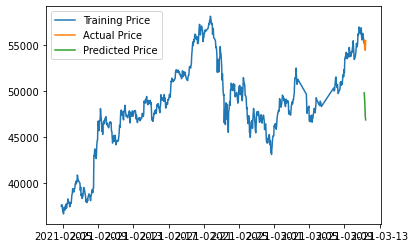

In [74]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = dataset_train[750:].index
train.index = dataset_train[:750].index

plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

In [75]:
preds=np.round(sigmoid(test_scores)) #convert score to 0 or 1
from sklearn.metrics import accuracy_score
print("Accuracy: "+str(accuracy_score(preds, y_valid.round(), normalize=False)))

Accuracy: 0


# K Nearest Neighbour

In [549]:
scaler = MinMaxScaler(feature_range=(0, 1))

#split into train and validation
train = dataset_train[:750]
valid = dataset_train[750:]

x_train = train.drop('close', axis=1)
y_train = train['close']
x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

In [550]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [551]:
#rmse
knn_rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
knn_rms

6945.997494207722

<ipython-input-553-1945932430b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
<ipython-input-553-1945932430b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


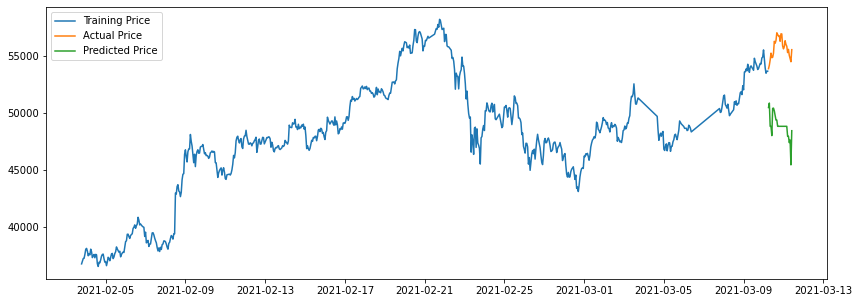

In [553]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Standard LSTM

In [460]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = dataset_train.index[i]
    new_data['Close'][i] = dataset_train['close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/10
690/690 - 11s - loss: 0.0057
Epoch 2/10
690/690 - 8s - loss: 0.0021
Epoch 3/10
690/690 - 9s - loss: 0.0015
Epoch 4/10
690/690 - 8s - loss: 0.0015
Epoch 5/10
690/690 - 8s - loss: 0.0012
Epoch 6/10
690/690 - 7s - loss: 9.9302e-04
Epoch 7/10
690/690 - 8s - loss: 9.7987e-04
Epoch 8/10
690/690 - 7s - loss: 0.0011
Epoch 9/10
690/690 - 7s - loss: 9.0922e-04
Epoch 10/10
690/690 - 7s - loss: 8.9241e-04


In [461]:
lstm_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_rms

551.0570863810728

<ipython-input-462-025710875cb5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


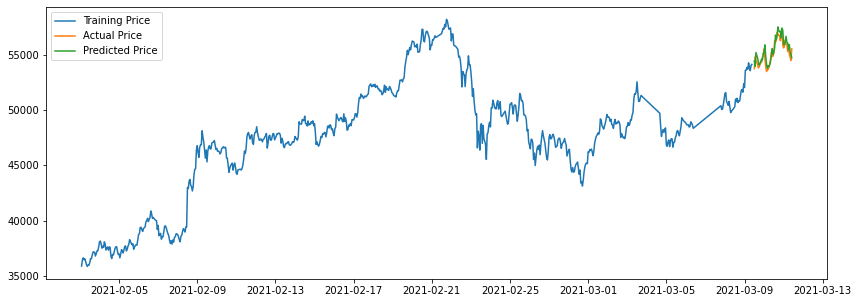

In [462]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Multivariate LSTM

In [5]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'Compound'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = df.index[i]
    new_data['Close'][i] = comp_df['close'][i]
    new_data['Compound'][i] = comp_df['compound'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values.astype('float')

train = dataset[0:650,:]
valid = dataset[650:,:]

sc_train = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc_train.fit_transform(train)
X_train = []
y_train = []
for i in range(60, len(train)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

sc_valid = MinMaxScaler(feature_range = (0, 1))
valid_set_scaled = sc_valid.fit_transform(valid)
X_valid = []
y_valid = []
for i in range(60, len(valid)):
    X_valid.append(valid_set_scaled[i-60:i, 0])
    y_valid.append(valid_set_scaled[i, 0]) 
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))



# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), batch_size=1, verbose=2)

print(history.history['loss'])
print(history.history['accuracy'])

Epoch 1/50
590/590 - 13s - loss: 0.0070 - accuracy: 0.0034 - val_loss: 0.0052 - val_accuracy: 0.0054
Epoch 2/50
590/590 - 7s - loss: 0.0031 - accuracy: 0.0034 - val_loss: 0.0048 - val_accuracy: 0.0054
Epoch 3/50
590/590 - 8s - loss: 0.0026 - accuracy: 0.0034 - val_loss: 0.0030 - val_accuracy: 0.0054
Epoch 4/50
590/590 - 8s - loss: 0.0022 - accuracy: 0.0034 - val_loss: 0.0027 - val_accuracy: 0.0054
Epoch 5/50
590/590 - 7s - loss: 0.0019 - accuracy: 0.0034 - val_loss: 0.0026 - val_accuracy: 0.0054
Epoch 6/50
590/590 - 7s - loss: 0.0020 - accuracy: 0.0034 - val_loss: 0.0020 - val_accuracy: 0.0054
Epoch 7/50
590/590 - 7s - loss: 0.0017 - accuracy: 0.0034 - val_loss: 0.0023 - val_accuracy: 0.0054
Epoch 8/50
590/590 - 7s - loss: 0.0016 - accuracy: 0.0034 - val_loss: 0.0019 - val_accuracy: 0.0054
Epoch 9/50
590/590 - 7s - loss: 0.0018 - accuracy: 0.0034 - val_loss: 0.0021 - val_accuracy: 0.0054
Epoch 10/50
590/590 - 8s - loss: 0.0015 - accuracy: 0.0034 - val_loss: 0.0023 - val_accuracy: 0.005

In [6]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = sc_valid.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = sc_valid.inverse_transform(inv_yhat)

In [7]:
valid = np.nan_to_num(valid)
lstm_comp_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_comp_rms

364.545674377841

<ipython-input-8-4c277704a6f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price[:,0]


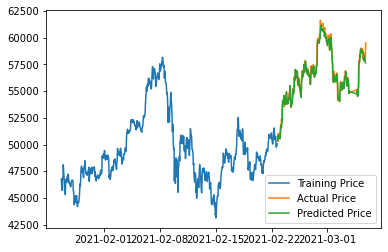

In [8]:
#for plotting
train = new_data[:650]
valid = new_data[650:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

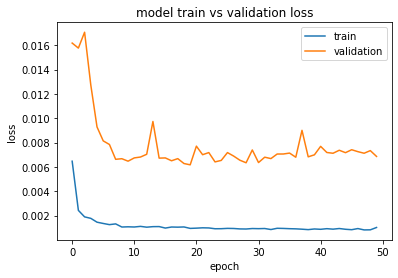

In [20]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# Multivariate LSTM Cross Entropy

In [23]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'Compound'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = df.index[i]
    new_data['Close'][i] = comp_df['close'][i]
    new_data['Compound'][i] = comp_df['compound'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values.astype('float')

train = dataset[0:650,:]
valid = dataset[650:,:]

sc_train = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc_train.fit_transform(train)
X_train = []
y_train = []
for i in range(60, len(train)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

sc_valid = MinMaxScaler(feature_range = (0, 1))
valid_set_scaled = sc_valid.fit_transform(valid)
X_valid = []
y_valid = []
for i in range(60, len(valid)):
    X_valid.append(valid_set_scaled[i-60:i, 0])
    y_valid.append(valid_set_scaled[i, 0]) 
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))



# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), batch_size=1, verbose=2)

print(history.history['loss'])
print(history.history['accuracy'])

Epoch 1/50
590/590 - 11s - loss: 0.6434 - accuracy: 0.0017 - val_loss: 0.5322 - val_accuracy: 0.0526
Epoch 2/50
590/590 - 6s - loss: 0.6365 - accuracy: 0.0017 - val_loss: 0.5301 - val_accuracy: 0.0526
Epoch 3/50
590/590 - 6s - loss: 0.6304 - accuracy: 0.0017 - val_loss: 0.5344 - val_accuracy: 0.0526
Epoch 4/50
590/590 - 6s - loss: 0.6317 - accuracy: 0.0017 - val_loss: 0.5327 - val_accuracy: 0.0526
Epoch 5/50
590/590 - 6s - loss: 0.6421 - accuracy: 0.0017 - val_loss: 0.5407 - val_accuracy: 0.0526
Epoch 6/50
590/590 - 6s - loss: 0.6291 - accuracy: 0.0017 - val_loss: 0.5567 - val_accuracy: 0.0526
Epoch 7/50
590/590 - 6s - loss: 0.6377 - accuracy: 0.0017 - val_loss: 0.5597 - val_accuracy: 0.0526
Epoch 8/50
590/590 - 6s - loss: 0.6400 - accuracy: 0.0017 - val_loss: 0.5195 - val_accuracy: 0.0526
Epoch 9/50
590/590 - 6s - loss: 0.6316 - accuracy: 0.0017 - val_loss: 0.5449 - val_accuracy: 0.0526
Epoch 10/50
590/590 - 6s - loss: 0.6272 - accuracy: 0.0017 - val_loss: 0.5277 - val_accuracy: 0.052

In [ ]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = sc_valid.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = sc_valid.inverse_transform(inv_yhat)

In [ ]:
valid = np.nan_to_num(valid)
lstm_comp_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_comp_rms

In [ ]:
#for plotting
train = new_data[:650]
valid = new_data[650:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# Multivariate LSTM SMA

In [570]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'SMA'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = dataset_train.index[i]
    new_data['Close'][i] = dataset_train['close'][i]
    new_data['SMA'][i] = dataset_train['sma'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
690/690 - 11s - loss: 0.0072
Epoch 2/10
690/690 - 8s - loss: 0.0023
Epoch 3/10
690/690 - 8s - loss: 0.0018
Epoch 4/10
690/690 - 8s - loss: 0.0016
Epoch 5/10
690/690 - 8s - loss: 0.0013
Epoch 6/10
690/690 - 8s - loss: 0.0011
Epoch 7/10
690/690 - 8s - loss: 0.0012
Epoch 8/10
690/690 - 8s - loss: 0.0011
Epoch 9/10
690/690 - 8s - loss: 9.0491e-04
Epoch 10/10
690/690 - 8s - loss: 9.3008e-04


In [571]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [572]:
lstm_sma_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_sma_rms

678.6901054863671

<ipython-input-573-884ef8ca4d3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price[:,0]


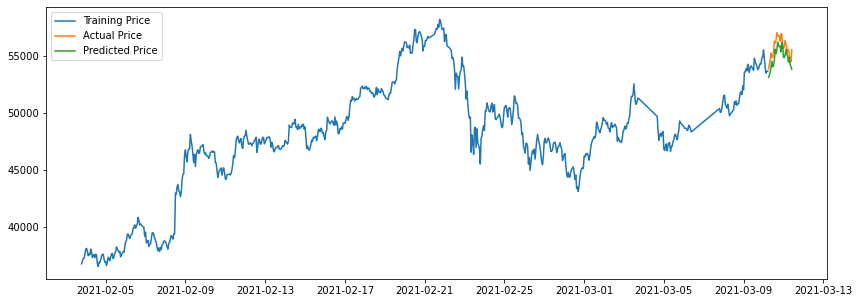

In [573]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

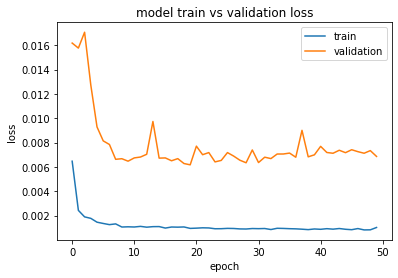

In [22]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# EMA MultiVariate LSTM

In [12]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'EMA'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = dataset_train.index[i]
    new_data['Close'][i] = dataset_train['close'][i]
    new_data['EMA'][i] = dataset_train['ema'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
690/690 - 10s - loss: 0.0060
Epoch 2/10
690/690 - 7s - loss: 0.0023
Epoch 3/10
690/690 - 7s - loss: 0.0018
Epoch 4/10
690/690 - 7s - loss: 0.0014
Epoch 5/10
690/690 - 7s - loss: 0.0012
Epoch 6/10
690/690 - 7s - loss: 0.0010
Epoch 7/10
690/690 - 7s - loss: 0.0011
Epoch 8/10
690/690 - 7s - loss: 0.0010
Epoch 9/10
690/690 - 7s - loss: 0.0011
Epoch 10/10
690/690 - 7s - loss: 0.0010


In [13]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [14]:
lstm_ema_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_ema_rms

440.7397073871837

<ipython-input-15-884ef8ca4d3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price[:,0]


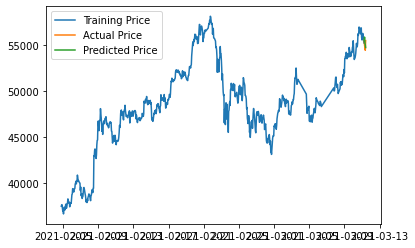

In [15]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Bin MultiVariate LSTM

In [578]:
bin_labels = [-1, -0.01, 0, 0.01, 1]

comp_df['compound'] = comp_df['compound'].fillna(0)
comp_df['rank'] = comp_df['compound'].rank(method='first')

comp_df['bin'] = pd.qcut(comp_df['rank'], q=5, labels=bin_labels)

In [537]:
#creating dataframe
data = comp_df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(comp_df)),columns=['Date', 'Close', 'Bin'])
for i in range(0,len(comp_df)):
    new_data['Date'][i] = comp_df.index[i]
    new_data['Close'][i] = comp_df['close'][i]
    new_data['Bin'][i] = comp_df['bin'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
690/690 - 10s - loss: 0.0046
Epoch 2/10
690/690 - 8s - loss: 0.0015
Epoch 3/10
690/690 - 7s - loss: 0.0012
Epoch 4/10
690/690 - 7s - loss: 0.0011
Epoch 5/10
690/690 - 7s - loss: 9.1107e-04
Epoch 6/10
690/690 - 7s - loss: 8.0726e-04
Epoch 7/10
690/690 - 7s - loss: 7.8448e-04
Epoch 8/10
690/690 - 7s - loss: 7.1568e-04
Epoch 9/10
690/690 - 7s - loss: 6.8414e-04
Epoch 10/10
690/690 - 7s - loss: 6.8845e-04


In [538]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [539]:
lstm_comp_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_comp_rms

762.7418659800528

<ipython-input-540-884ef8ca4d3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price[:,0]


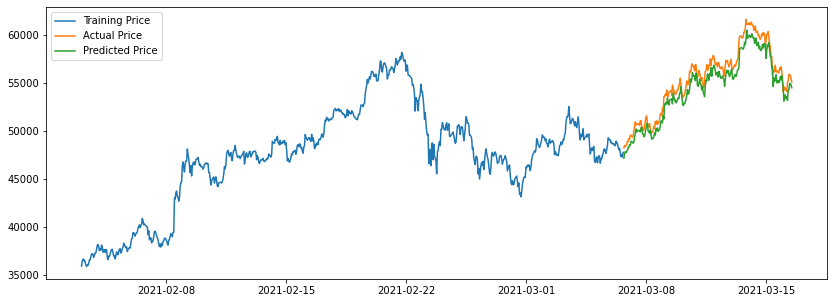

In [540]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Bin SMA MultiVariate LSTM

In [ ]:
bin_labels = [-1, -0.01, 0, 0.01, 1]

dataset_train['bin'] = pd.qcut(dataset_train['sma'], q=5, labels=bin_labels)

In [ ]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'Bin'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = dataset_train.index[i]
    new_data['Close'][i] = dataset_train['close'][i]
    new_data['Bin'][i] = dataset_train['bin'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

In [ ]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [ ]:
lstm_sma_bin_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_sma_bin_rms

In [ ]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Bin EMA MultiVariate LSTM

In [ ]:
bin_labels = [-1, -0.01, 0, 0.01, 1]

dataset_train['bin'] = pd.qcut(dataset_train['ema'], q=5, labels=bin_labels)

In [ ]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'Bin'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = dataset_train.index[i]
    new_data['Close'][i] = dataset_train['close'][i]
    new_data['Bin'][i] = dataset_train['bin'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

In [ ]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [ ]:
lstm_ema_bin_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_ema_bin_rms

In [ ]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Evaluation

In [ ]:
# Create a Dataframe with the results.
d = {'Classifiers': ['Linear Regression', 'KNN','Standard LSTM', 'LSTM with SMA', 'LSTM with Binned SMA', 'LSTM with EMA', 'LSTM with Binned EMA'], 
    'Root Mean Square': [lr_rms, knn_rms, lstm_rms, lstm_sma_rms, lstm_sma_bin_rms, lstm_ema_rms, lstm_ema_bin_rms]}

result_df = pd.DataFrame(data=d)

In [ ]:
print(result_df.sort_values(by='Root Mean Square', ascending=True))